<span style="font-size:18px; color:red; font-weight:bold">Churn Bancario, construyendo un modelo de Machine Learning en PySpark en notebook en Fabric</span>

**Enrique Aranaz Tudela**

LInkedin: www.linkedin.com/in/enrique-aranaz-tudela

In [1]:
from pyspark.sql import SparkSession

# Crear una sesión de Spark
spark = SparkSession.builder.appName("MiAplicacionSpark").getOrCreate()

# Configurar el nivel de logging
spark.sparkContext.setLogLevel("ERROR")


StatementMeta(, 24a44ea7-b232-44d8-8f5f-656caef7e501, 3, Finished, Available, Finished)

StatementMeta(, 24a44ea7-b232-44d8-8f5f-656caef7e501, 4, Finished, Available, Finished)

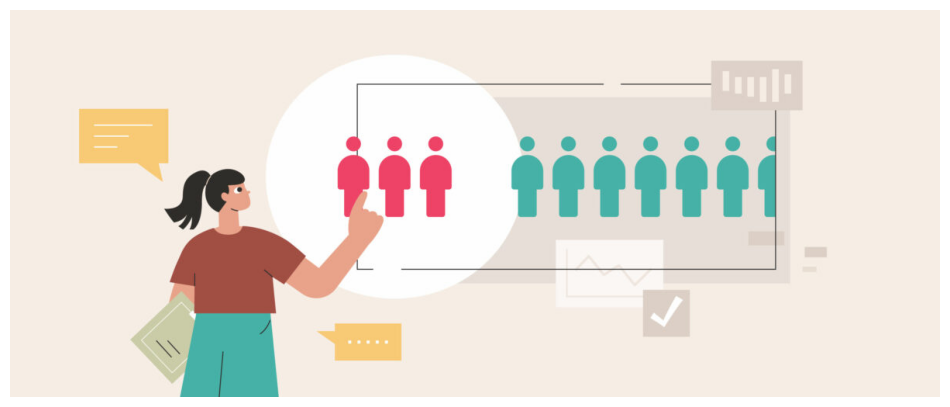

In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
def mostrar_imagen(ruta_imagen):
    img = mpimg.imread(ruta_imagen)
    plt.figure(figsize=(12, 10))
    imgplot = plt.imshow(img)
    plt.axis('off')  # Desactivar los ejes
    plt.show()

mostrar_imagen('/lakehouse/default/Files/Churn.jpeg')

<span style="font-size:24px; color:red; font-weight:bold">Indice</span>

<span style="font-size:18px; color:red; font-weight:bold">0. Importación de librerias a utilizar y definición de funciones</span>

<span style="font-size:18px; color:red; font-weight:bold">1. Definición del problema</span>

    1.1 Introducción al problema que queremos abordar
    1.2 Descripción del dataset y sus variables

<span style="font-size:18px; color:red; font-weight:bold">2. Preparación de los datos</span>

    2.1 Importación de librerias a utilizar
    2.2 Carga del dataset y descripción de los datos
    2.3 Data Cleaning 

        2.3.1 Identificación valores nulos, duplicados, valores no utiles para el modelo o con poca varianza
        2.3.2 Analisis descriptivo univariante y bivariante
        2.3.3 Identificación de valores atípicos y definición de estrategias con ellos
        2.3.4 Data Transforms: Cambiando la escala o distribución de las variables

    2.4 Feature Selection: Identificación de las variables más relevantes

        2.4.1 Filter Methods: Correlación, Chi-cuadrado y Anova
        2.4.2 Filter Methods empleando el metodo K-best
        2.4.3 Embedded Methods: RandomForest

        2.4.4 Conclusiones Feature Selection

    2.5 Reducción de la dimensionalidad de los datos
    2.6 Feature engineering: Creación de nuevas variables

<span style="font-size:18px; color:red; font-weight:bold">3. Entrenamiento y evaluación de modelos</span>

    3.1 Elección de algoritmos de machine learning adecuados para el problema.
    3.2 Aplicación de RamdonOverSampler para corregir problema de desequilibrio. 
    3.3 Entrenamiento de los modelos y evaluación de su rendimiento. 
    3.4 Selección de los dos mejores modelos y optimización (ajuste hiperparámetros).

<span style="font-size:18px; color:red; font-weight:bold">4. Modelo final</span>

    4.1 Añadir las probabilidades obtenidas por el modelo al dataset
    4.2 Segmentación de nuestra cartera de clientes y descripción de cada segmento en función de las características más relevantes

<span style="font-size:18px; color:red; font-weight:bold">5. Conclusiones y recomendaciones</span>

In [3]:
# Librerias básicas:
import numpy as np
import pandas as pd
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import pylab
import matplotlib.ticker as mtick
import matplotlib.image as mpimg
from scipy.stats import shapiro, normaltest, kstest, jarque_bera
from scipy.stats import probplot
from scipy.stats import stats
from scipy.stats import mstats

# Feature Selection, Preprocesado, Modelos, Métricas, GridSearch:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import MinMaxScaler
!pip install imbalanced-learn
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
!pip install mlxtend
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score,f1_score,accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_digits

import warnings
warnings.filterwarnings("ignore")

StatementMeta(, 24a44ea7-b232-44d8-8f5f-656caef7e501, 5, Finished, Available, Finished)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 32.6 MB/s eta 0:00:00a 0:00:01


In [4]:
import warnings

# Ignorar todas las advertencias
warnings.filterwarnings("ignore")

# O ignorar advertencias específicas
warnings.filterwarnings("ignore", category=DeprecationWarning)

StatementMeta(, 24a44ea7-b232-44d8-8f5f-656caef7e501, 6, Finished, Available, Finished)

In [5]:
# Funciones vamos a utilizar

def plot_vector_charts(vector_cols, titulo):
    # Definir una paleta de colores personalizada
    color_palette = ["#800000", "#8000ff", "#6aac90", "#5833ff", "#da8829"]
    color_pastel = ["#53D021", "#EB2325"]
    bar_palette = {0: 'blue', 1: 'red'}
    colors = ["#53D021", '#EB2325']
    
    # Configurar la figura con constrained_layout
    fig, axes = plt.subplots(len(vector_cols), 2, figsize=(16, 8))  # Aumentar el ancho de la figura
    fig.patch.set_facecolor("#ffe6e6")

    # Título del gráfico
    fig.suptitle(titulo, fontsize=10, fontweight='bold', fontfamily='serif', color="#000000")

    # Crear gráficos de pastel y de barras para cada columna categórica
    for i, col in enumerate(vector_cols):
        # Gráfico de pastel
        pie_ax = axes[i, 0]
        (df[col].value_counts() * 100.0 / len(df)).plot.pie(
            autopct=lambda p: f'{p:.1f}%', fontsize=8, ax=pie_ax, colors=color_palette, textprops={'color': 'black'})
        pie_ax.set_ylabel('')
        pie_ax.set_title(col, fontsize=8, backgroundcolor='skyblue')

        # Agrupar datos por la columna actual y estado de salida
        churn_data = df.groupby([col, 'Exited']).size().unstack()

        # Crear gráfico de barras apiladas
        bar_ax = axes[i, 1]
        ax = churn_data.plot(kind='bar', stacked=True, color=colors, rot=0, ax=bar_ax)
        ax.legend(labels=['Stayed', 'Churned'], fontsize=8)  # Tamaño de la leyenda reducido
        ax.set_title(f'{col} Distribution and Churn rate', fontsize=8)  # Tamaño del título reducido
        ax.set_ylabel('Customer Count')

        # Añadir anotaciones de porcentaje
        for p in ax.patches:
            w, h = p.get_width(), p.get_height()
            x, y = p.get_xy()
            if x == -0.25:
                col_sum = churn_data.T.sum().iloc[0]
            else:
                col_sum = churn_data.T.sum().iloc[1]

            temp = np.array(round(h * 100 / col_sum, 1))  # Redondear a un decimal
            anot = str(temp)
            ax.annotate(anot + '%', (x + 0.15, y + h / 2), color='white', weight='bold', size=8)  # Tamaño de fuente reducido

        # Añadir líneas discontinuas al eje y
        ax.grid(color='#000000', linestyle=':', axis='y', zorder=0, dashes=(1, 5))

    # Ajustar manualmente el diseño para aumentar el espacio vertical entre gráficos
    plt.subplots_adjust(hspace=0.6, wspace=0.2)  # Reducir el espacio horizontal entre subplots
    plt.show()

def mostrar_imagen(ruta_imagen):
    img = mpimg.imread(ruta_imagen)
    plt.figure(figsize=(12, 10))
    imgplot = plt.imshow(img)
    plt.axis('off')  # Desactivar los ejes
    plt.show()

def plot_chart(titulo):

    # Configurar la figura
    fig, ax = plt.subplots(figsize=(8, 4))
    background_color = "#ffe6e6"
    fig.patch.set_facecolor(background_color)
    ax.set_facecolor(background_color)

    # Crear el gráfico de barras horizontal
    sns.barplot(x='f1_score', y='Modelo', hue='Modelo', data=Model_com_df, ax=ax, palette='viridis', legend=False)

    # Añadir etiquetas y título
    ax.set_title(titulo, fontsize=10, fontweight='bold')
    ax.set_xlabel('f1_score', fontsize=12)
    ax.set_ylabel('Modelo', fontsize=12)

    # Añadir valores de f1_score a las barras con un decimal
    for p in ax.patches:
        width = p.get_width()
        ax.annotate(f'{width:.2f}', xy=(width, p.get_y() + p.get_height() / 2),
                xytext=(3, 0), textcoords="offset points", fontsize=8, fontweight='bold')

    # Mostrar el gráfico
    plt.show()

def evaluationModel(y_test, y_pred):
    # Calcular la matriz de confusión
    cn = confusion_matrix(y_test, y_pred)
    
    # Calcular el porcentaje de cada celda sobre el total de la fila
    cn_percent = cn / cn.sum(axis=1, keepdims=True) * 100
    
    # Nombres personalizados para las celdas
    names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    
    # Crear anotaciones combinadas de nombres, números absolutos y porcentajes
    combined_labels = np.array([f'{name}\n{value}\n{percent:.2f}%' for name, value, percent in zip(names, cn.flatten(), cn_percent.flatten())]).reshape(2, 2)
    
    # Crear el heatmap
    sns.heatmap(cn, annot=combined_labels, fmt='', cmap='Blues', cbar=False, xticklabels=['Predicted No Churn', 'Predicted Churn'], yticklabels=['Actual No Churn', 'Actual Churn'])
    
    # Añadir etiquetas y título
    plt.xlabel('Predicted Label')  
    plt.ylabel('True Label')  
    plt.title('Confusion Matrix') 
    plt.show()

StatementMeta(, 24a44ea7-b232-44d8-8f5f-656caef7e501, 7, Finished, Available, Finished)

<span style="font-size:24px; color:red; font-weight:bold">1. Definición del problema</span>

### 1.1 Introducción al problema que queremos abordar

La **pérdida de clientes**, consecuencia de la acelerada transformación bancaria y del resurgimiento de nuevos competidores, **es uno de los principales problemas que afronta la banca actual con impacto significativo en su rentabilidad.** 

**Dos son los objetivos de este proyecto:**  

 1) Desarrollar un modelo de predicción del churn que permita comprender los factores más determinantes en la fuga de clientes. 

 2) Utilizar dicho modelo para predecir una probabilidad de churn para nuestra cartera de clientes que nos permita anticiparnos con acciones destinadas a mitigarlo, muy en especial, de forma específica, en los clientes más valiosos para la compañía.

**Para realizar el proyecto se emplearan técnicas de Machine Learning utilizando el lenguaje de ciencia de datos Python**, lo que nos permitirá abordar el problema en todas sus fases, desde la preparación de los datos a la evaluación de distintos modelos y la selección final del más adecuado al objetivo buscado, **creando así una metodología eficiente y automatizable que permita replicarse de forma ágil sobre nuestra cartera de clientes a lo largo del tiempo**, ajustándose el modelo en función de nuevas variables disponibles y/o de cambios en el comportamiento respecto al churn de los clientes.

### 1.2 Descripción del dataset y sus variables

StatementMeta(, 036f5dad-b40d-48e2-9f9d-0357c9b2db50, 39, Finished, Available, Finished)

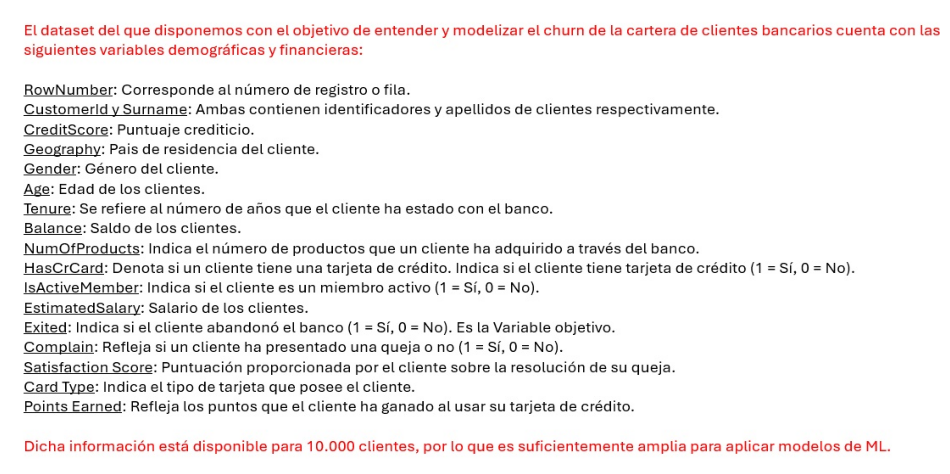

In [37]:
mostrar_imagen('/lakehouse/default/Files/DescripcionDF.jpg')

<span style="font-size:24px; color:red; font-weight:bold">2. Preparación de los datos</span>

### 2.2 Carga del dataset y descripción de los datos

In [6]:
# Load data into pandas DataFrame from "/lakehouse/default/Files/Customer-Churn-Records.csv"
#df = pd.read_csv("/lakehouse/default/Files/Customer-Churn-Records.csv")

#Cargamos datos de Customer
df_spark = spark.sql("SELECT * FROM LakehousePhyton.customers")
display(df_spark)

StatementMeta(, 24a44ea7-b232-44d8-8f5f-656caef7e501, 8, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, ef677f91-f26e-4f73-be91-5f3a04bc7c8c)

In [7]:
print(type(df_spark))

# Convertir el DataFrame de PySpark a un DataFrame de pandas
df = df_spark.toPandas()

# Verificar el tipo para asegurarte de que es un DataFrame de pandas
print(type(df))



StatementMeta(, 24a44ea7-b232-44d8-8f5f-656caef7e501, 9, Finished, Available, Finished)

<class 'pyspark.sql.dataframe.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


### 2.3 Data Cleaning 

### 2.3.1 Identificación valores nulos, duplicados, valores no utiles para el modelo o con poca varianza

In [8]:
# dimension de los datos
print("El tamaño del dataset es : ", df.shape)
print("")

# Eliminamos columnas innecesarias
df=df.drop(columns = ['CustomerId','RowNumber', 'Surname'],axis=1)

#Cambiamos nombres columnas con espacios
df.columns = df.columns.str.replace(' ', '_')

# Chequear valores duplicados
print("---- Duplicados ----")
print("Número de duplicados: " + str(df.duplicated().sum()))
print("")

#Valores nulos
dict = {}
for i in list(df.columns):
    dict[i] = df[i].isnull().mean() * 100

df_nulos=pd.DataFrame(dict,index=["Valores nulos"]).transpose()

#Valores únicos
dict = {}
for i in list(df.columns):
    dict[i] = df[i].value_counts().shape[0]

df_unicos=pd.DataFrame(dict,index=["Valores únicos"]).transpose()

#Valores missing
dict = {}
for i in list(df.columns):
    dict[i] = df[i].isna().mean() * 100
    
df_miss=pd.DataFrame(dict,index=["Valores missing"]).transpose()

#type variable
dict = {}
for i in list(df.columns):
    dict[i] = df[i].dtype
    
df_type=pd.DataFrame(dict,index=["Type"]).transpose()

# Concatenar 
pd.concat([df_unicos,df_nulos,df_miss, df_type ], axis=1)

StatementMeta(, 24a44ea7-b232-44d8-8f5f-656caef7e501, 10, Finished, Available, Finished)

El tamaño del dataset es :  (10000, 18)

---- Duplicados ----
Número de duplicados: 0



Valores únicos  Valores nulos  Valores missing     Type
CreditScore                    460            0.0              0.0    int64
Geography                        3            0.0              0.0   object
Gender                           2            0.0              0.0   object
Age                             70            0.0              0.0    int64
Tenure                          11            0.0              0.0    int64
Balance                       6382            0.0              0.0  float64
NumOfProducts                    4            0.0              0.0    int64
HasCrCard                        2            0.0              0.0    int64
IsActiveMember                   2            0.0              0.0    int64
EstimatedSalary               9999            0.0              0.0  float64
Exited                           2            0.0              0.0    int64
Complain                         2            0.0              0.0    int64
Satisfaction_Score               5            0.0              0.0    int64
Card_Type                        4            0.0              0.0   object
Point_Earned                   785            0.0              0.0    int64

### 2.3.2 Analisis descriptivo univariante y bivariante

Vamos a dividir las variables en binarias, categoricas, numéricas discretas y numéricas continuas.

StatementMeta(, 24a44ea7-b232-44d8-8f5f-656caef7e501, 11, Finished, Available, Finished)

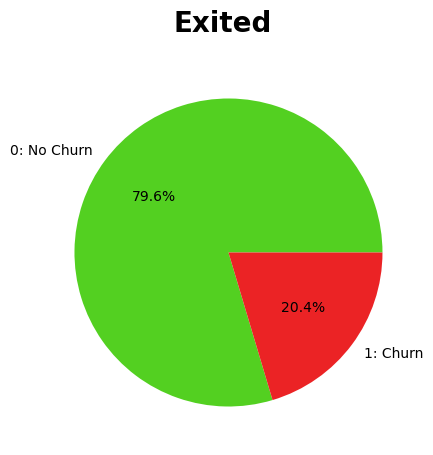

In [9]:
# a) Variable Objetivo

# Visualizamos la variable objetivo para ver si esta balanceada
# Definir los colores
colors = ["#53D021", "#EB2325"]

# Definir las etiquetas
labels = ['0: No Churn', '1: Churn']

# Crear la figura
plt.figure(figsize=(5, 5))
plt.suptitle("Exited", fontweight="bold", fontsize=20)

# Crear el gráfico de pastel con los colores definidos
plt.pie(x=df['Exited'].value_counts().values, labels=labels, colors=colors, autopct='%.1f%%')

# Mostrar el gráfico
plt.show()

In [11]:
# b) Variables binarias, excepto la variable objetivo

binary_cols = [col for col in df.columns if df[col].nunique() == 2 and col != 'Exited' and df[col].dtype != 'object']
df_binary_cols= df[binary_cols]

# c) Variables categoricas
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
df_categorical_cols = df[categorical_cols]

# d) Variables discretas
# Seleccionar columnas numéricas con menos de 12 valores únicos y más de 2 valores únicos
numerical_columns = df.select_dtypes(include=['number']).columns
discretas_cols = [col for col in numerical_columns if 2 < df[col].nunique() < 12]
discretas_cols

# e) Variables numéricas continuas  (con >=12 valores unicos)
numerical_columns = df.select_dtypes(include=['number']).columns
numerical_cont_cols = [col for col in numerical_columns if df[col].nunique() >= 12]
df_numerical_cont_cols = df[numerical_cont_cols]

StatementMeta(, 24a44ea7-b232-44d8-8f5f-656caef7e501, 13, Finished, Available, Finished)

StatementMeta(, 71a85b1a-cfd1-49f7-b217-b4a410ba84d5, 14, Finished, Available, Finished)

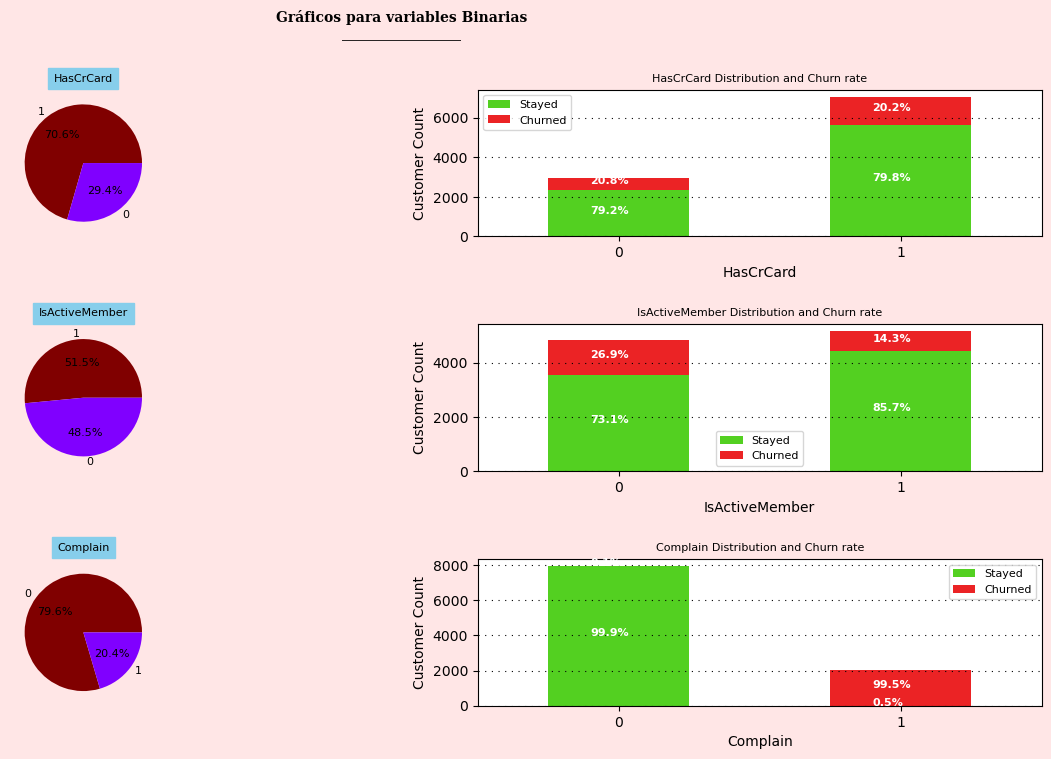

In [12]:
titulo = 'Gráficos para variables Binarias\n_________________'
plot_vector_charts(binary_cols, titulo)

StatementMeta(, 71a85b1a-cfd1-49f7-b217-b4a410ba84d5, 15, Finished, Available, Finished)

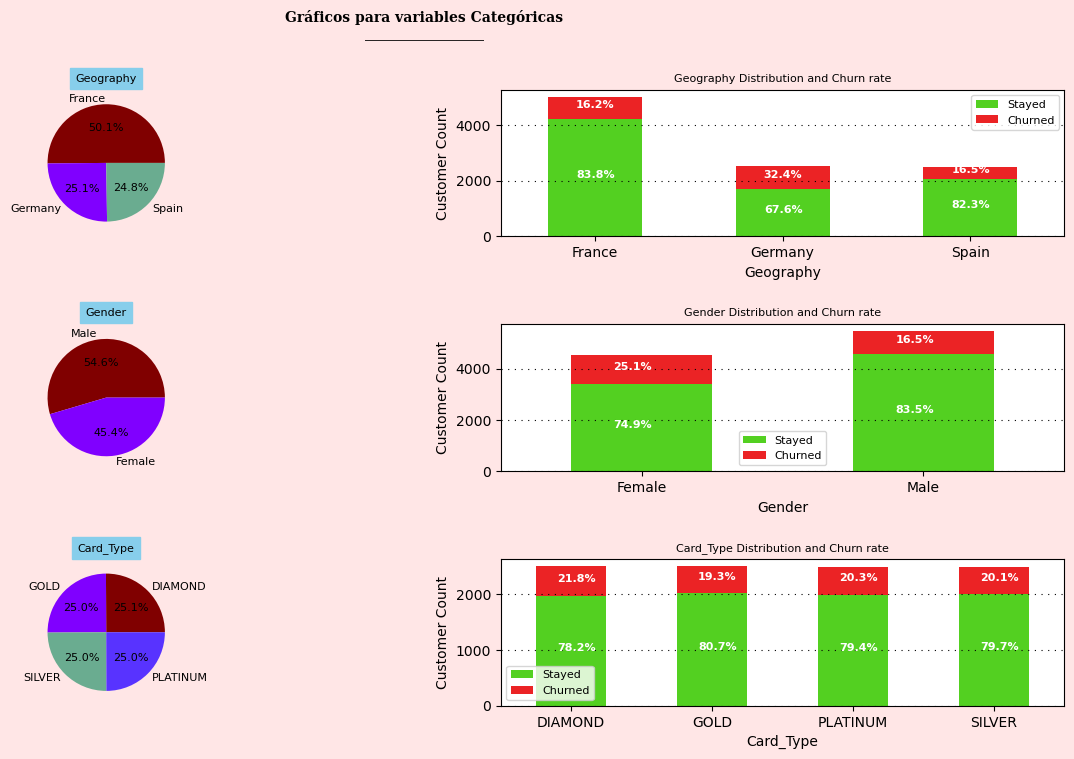

In [13]:
titulo = 'Gráficos para variables Categóricas\n_________________'
plot_vector_charts(categorical_cols, titulo)

StatementMeta(, 036f5dad-b40d-48e2-9f9d-0357c9b2db50, 63, Finished, Available, Finished)

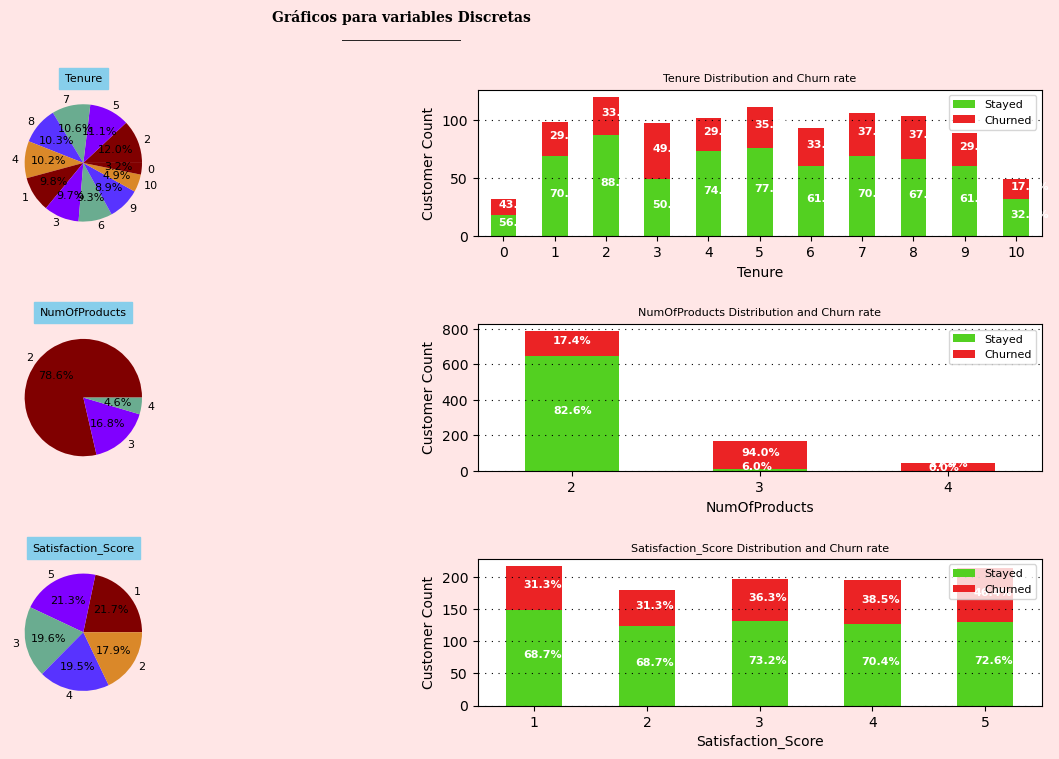

In [61]:
titulo = 'Gráficos para variables Discretas\n_________________'
plot_vector_charts(discretas_cols, titulo)

StatementMeta(, 24a44ea7-b232-44d8-8f5f-656caef7e501, 14, Finished, Available, Finished)

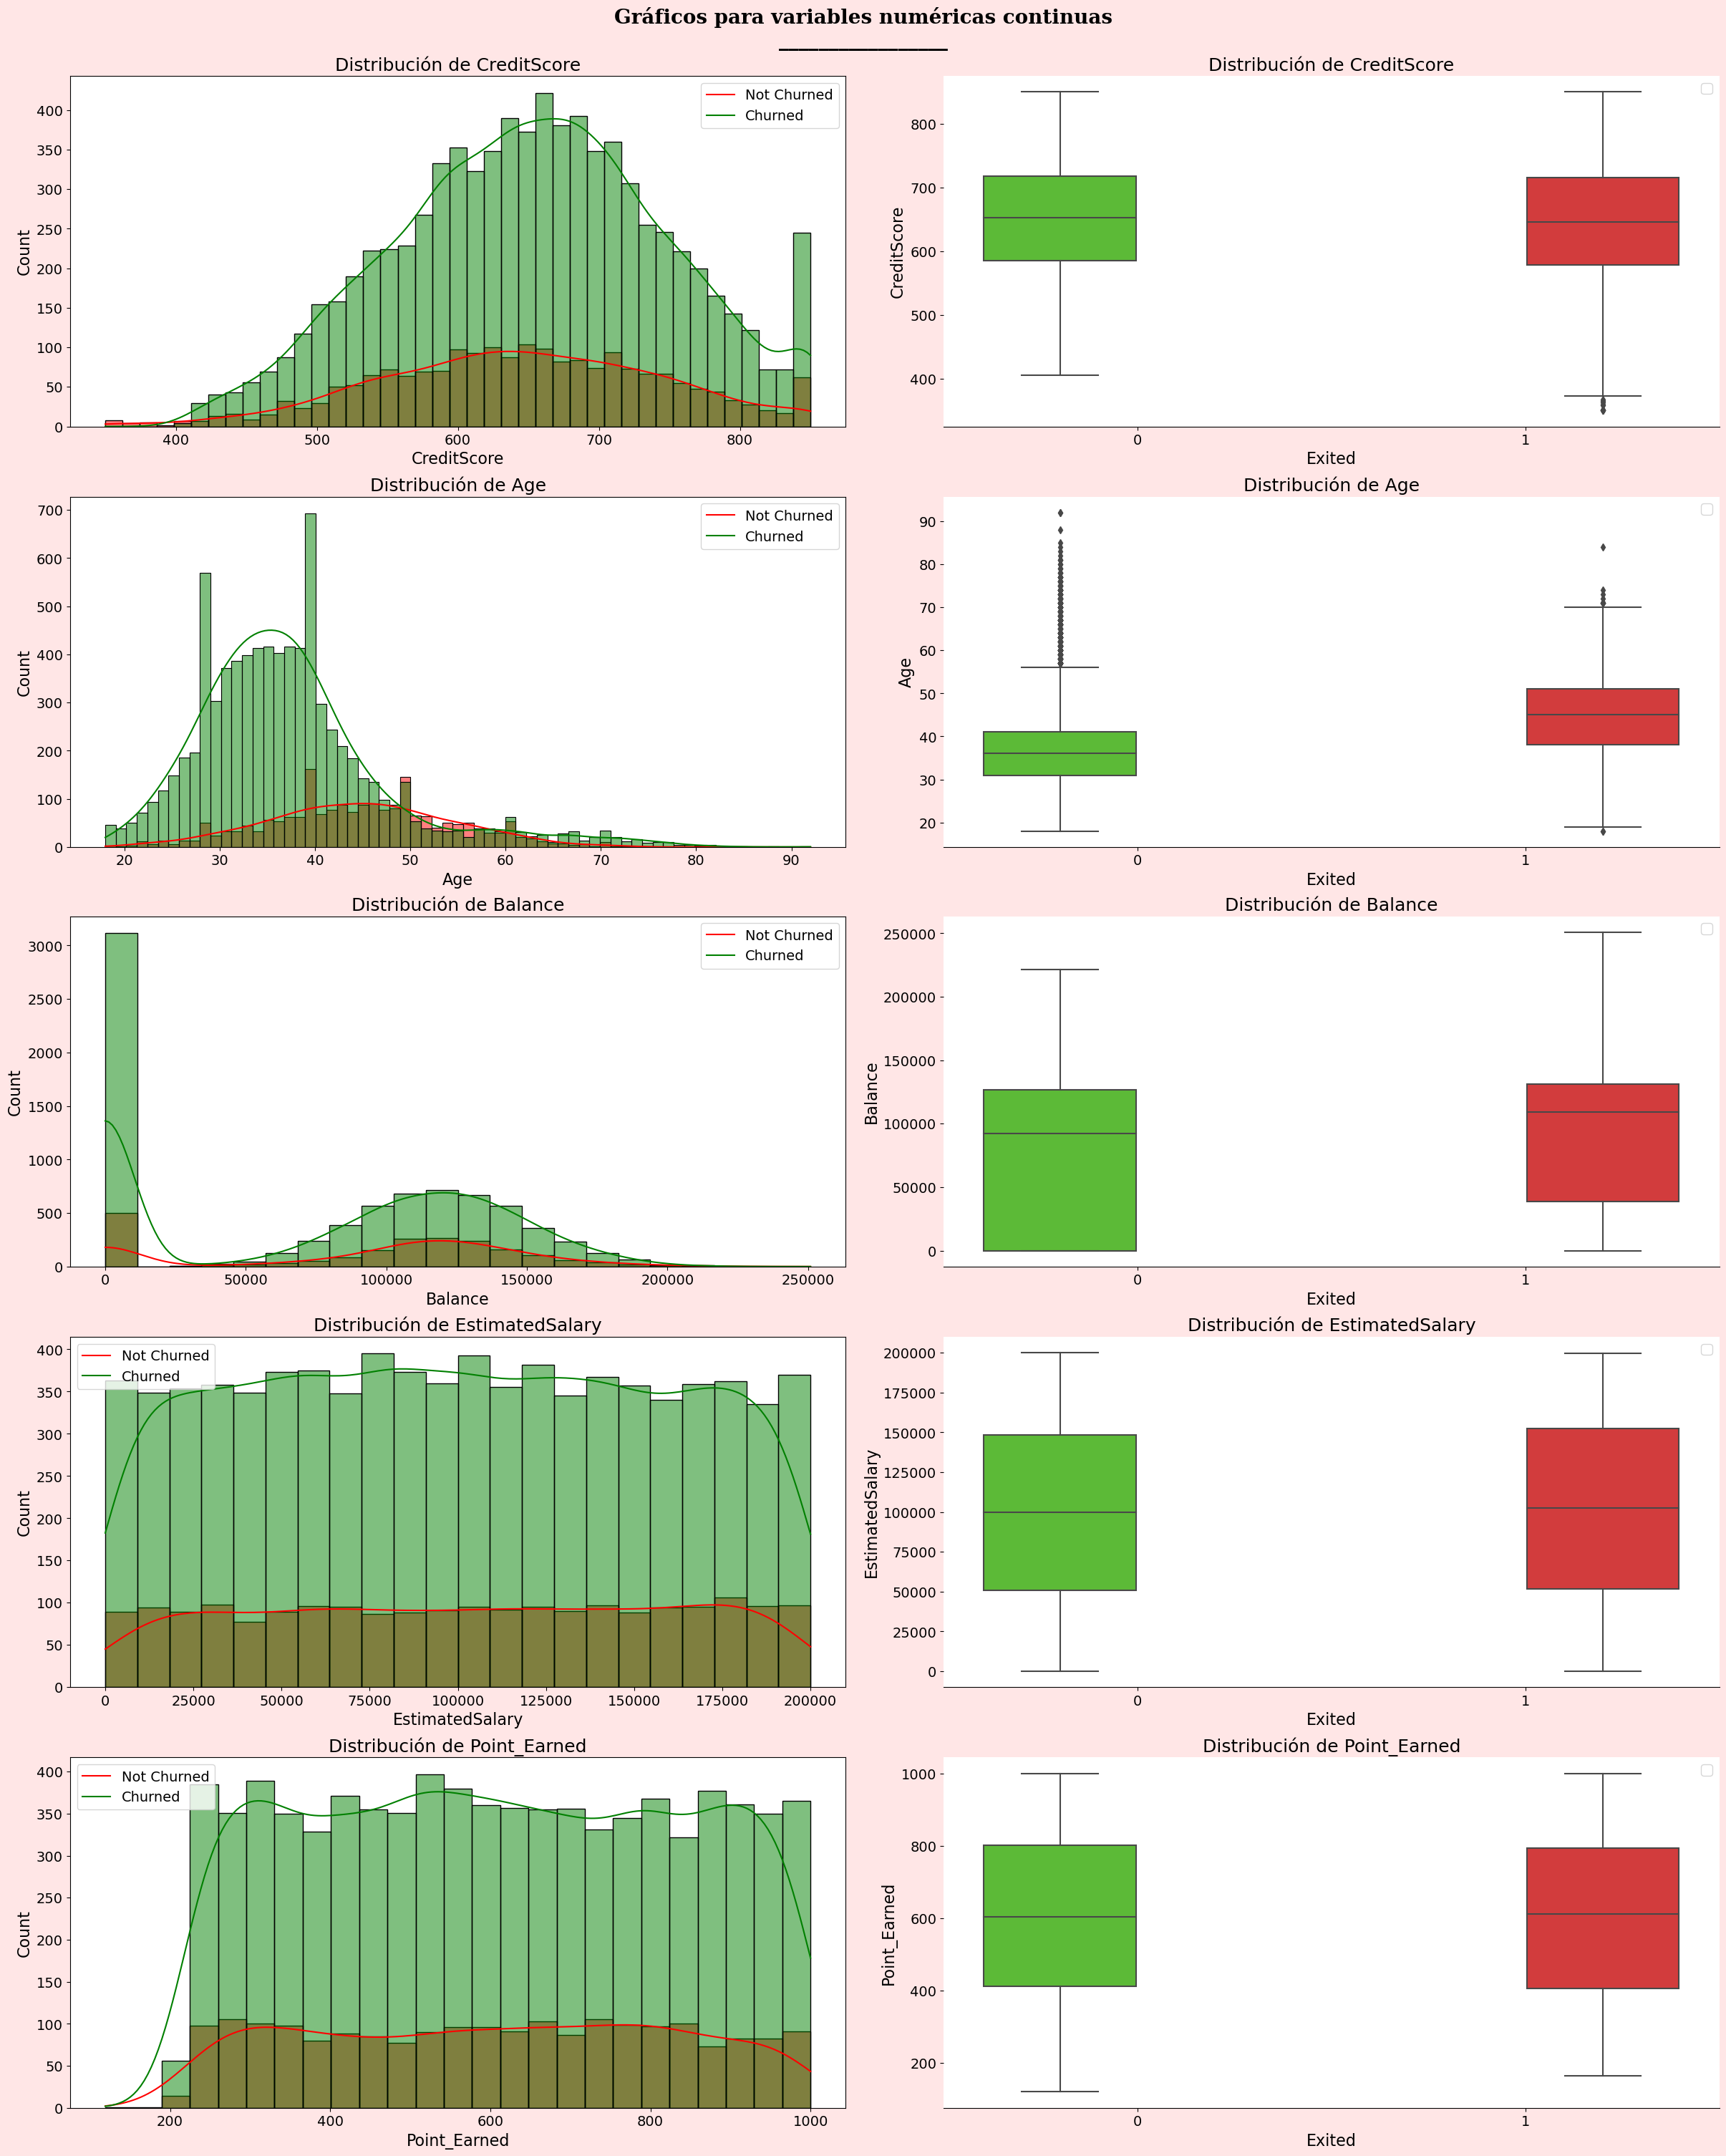

In [12]:
# Definir una paleta de colores personalizada
custom_palette = ["#800000", "#8000ff", "#6aac90", "#5833ff", "#da8829"]
bar_palette = {0: 'green', 1: 'red'}
colors = ["#53D021", "#EB2325"]

# Configurar la figura con constrained_layout
fig, axes = plt.subplots(len(numerical_cont_cols), 2, figsize=(24, len(numerical_cont_cols) * 6), constrained_layout=True)  # Aumentar la altura de la figura
fig.patch.set_facecolor("#ffe6e6")

# Título del gráfico
fig.suptitle('Gráficos para variables numéricas continuas\n_________________', 
             fontsize=20, fontweight='bold', fontfamily='serif', color="#000000") 

# Crear gráficos de histograma con KDE y de caja para cada columna numérica continua
for i, col in enumerate(numerical_cont_cols):
    # Histograma con KDE
    hist_ax = axes[i, 0]
    sns.histplot(ax=hist_ax, x=col, hue='Exited', data=df, kde=True, palette=bar_palette)
    hist_ax.set_xlabel(col, fontsize=16)  
    hist_ax.set_ylabel('Count', fontsize=16)  
    hist_ax.set_title(f'Distribución de {col}', fontsize=18) 
    hist_ax.legend(['Not Churned', 'Churned'], fontsize=14)  
    hist_ax.tick_params(axis='both', which='major', labelsize=14) 

    # Gráfico de caja
    box_ax = axes[i, 1]
    sns.boxplot(ax=box_ax, x='Exited', y=col, hue='Exited', data=df, palette=colors)
    box_ax.set_title(f'Distribución de {col}', fontsize=18) 
    box_ax.set_xlabel('Exited', fontsize=16)  
    box_ax.set_ylabel(col, fontsize=16)  
    box_ax.legend([], fontsize=14)  
    box_ax.tick_params(axis='both', which='major', labelsize=14) 
    for s in ["top", "right", "left"]:
        box_ax.spines[s].set_visible(False)

plt.show()

StatementMeta(, 24a44ea7-b232-44d8-8f5f-656caef7e501, 15, Finished, Available, Finished)

<Figure size 2000x2000 with 0 Axes>

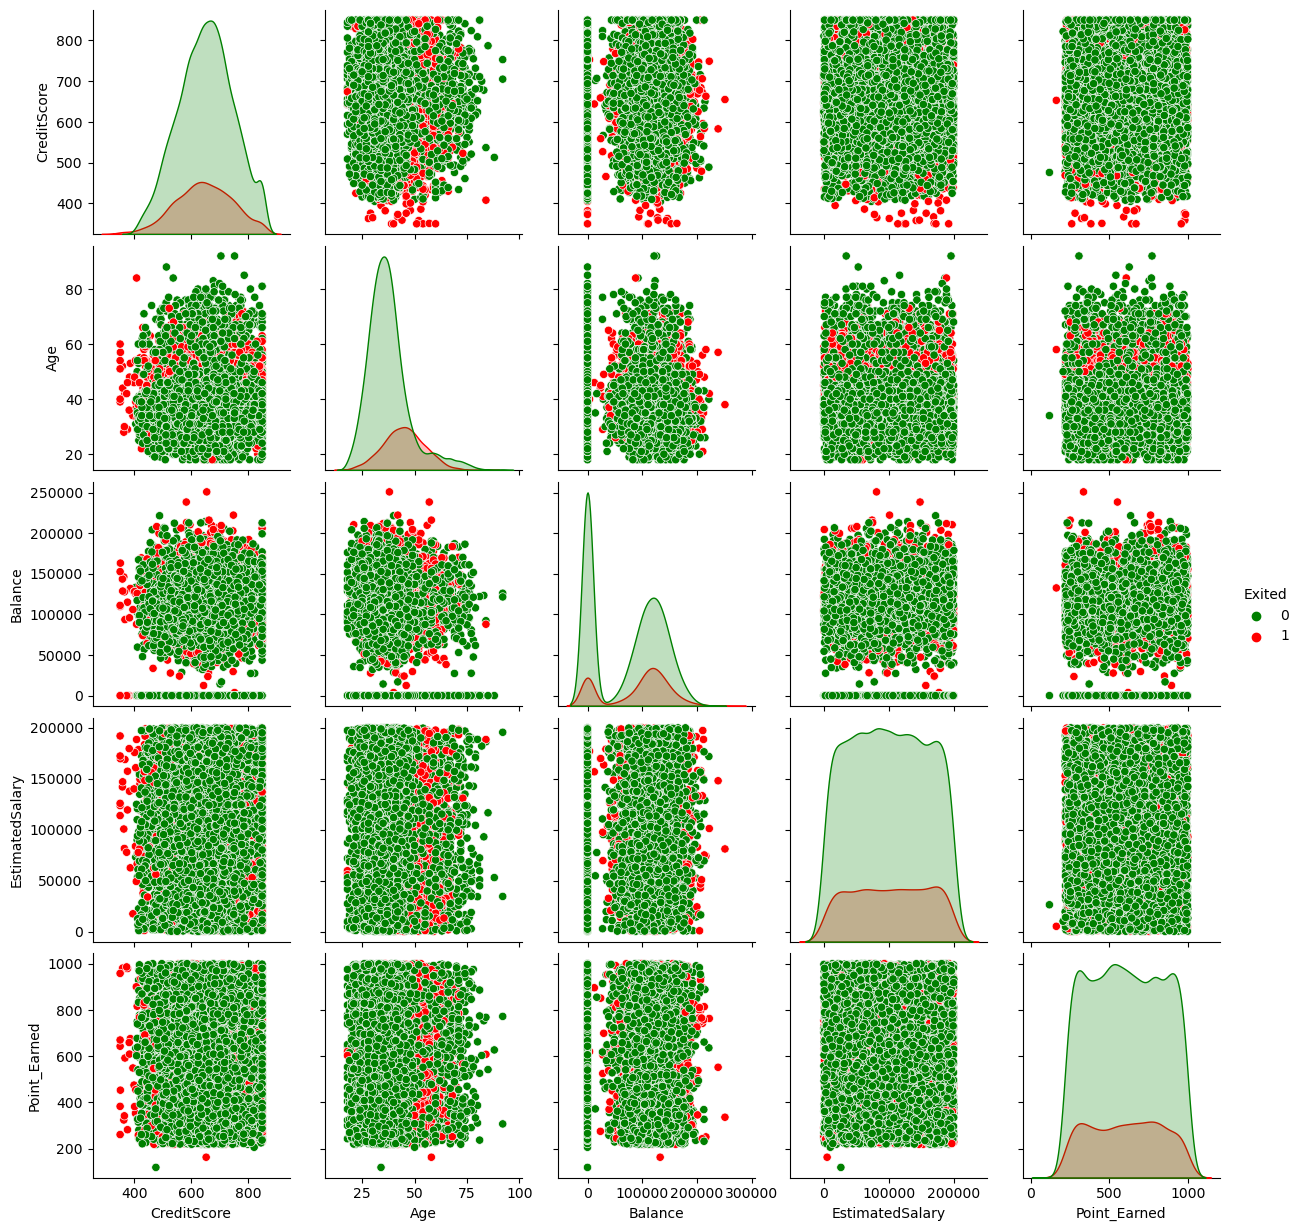

In [13]:
# Definir una paleta de colores personalizada
palette = {0: 'green', 1: 'red'}

# Configurar la figura
fig = plt.figure(figsize=(20, 20))
background_color = "#ffe6e6"
fig.patch.set_facecolor(background_color)

# Añadir 'Exited' a la lista de columnas pues no está incluida
if 'Exited' not in numerical_cont_cols:
    numerical_cont_cols.append('Exited')

# Crear el pairplot
pairplot = sns.pairplot(df[numerical_cont_cols], hue='Exited', palette=palette)

# Configurar el fondo de los ejes del pairplot
for ax in pairplot.axes.flatten():
    ax.set_facecolor('white')  # Fondo blanco para cada gráfico

# Fondo general
fig.patch.set_facecolor(background_color)

# Mostrar el gráfico
numerical_cont_cols.remove('Exited')
plt.show()

StatementMeta(, 71a85b1a-cfd1-49f7-b217-b4a410ba84d5, 18, Finished, Available, Finished)

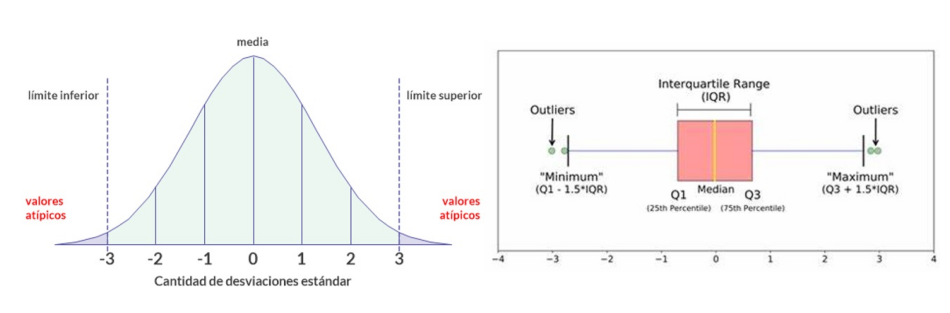

In [16]:
mostrar_imagen('/lakehouse/default/Files/CorrecionAtipicos.jpg')


Vamos a analizar la presencia de atípicos en las variables numéricas continuas , para lo que emplearemos dos metodos: IQR y +- 3 desv. tipicas

StatementMeta(, 24a44ea7-b232-44d8-8f5f-656caef7e501, 16, Finished, Available, Finished)

---- Outliers en variables númericas continuas ----

['CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'Point_Earned']



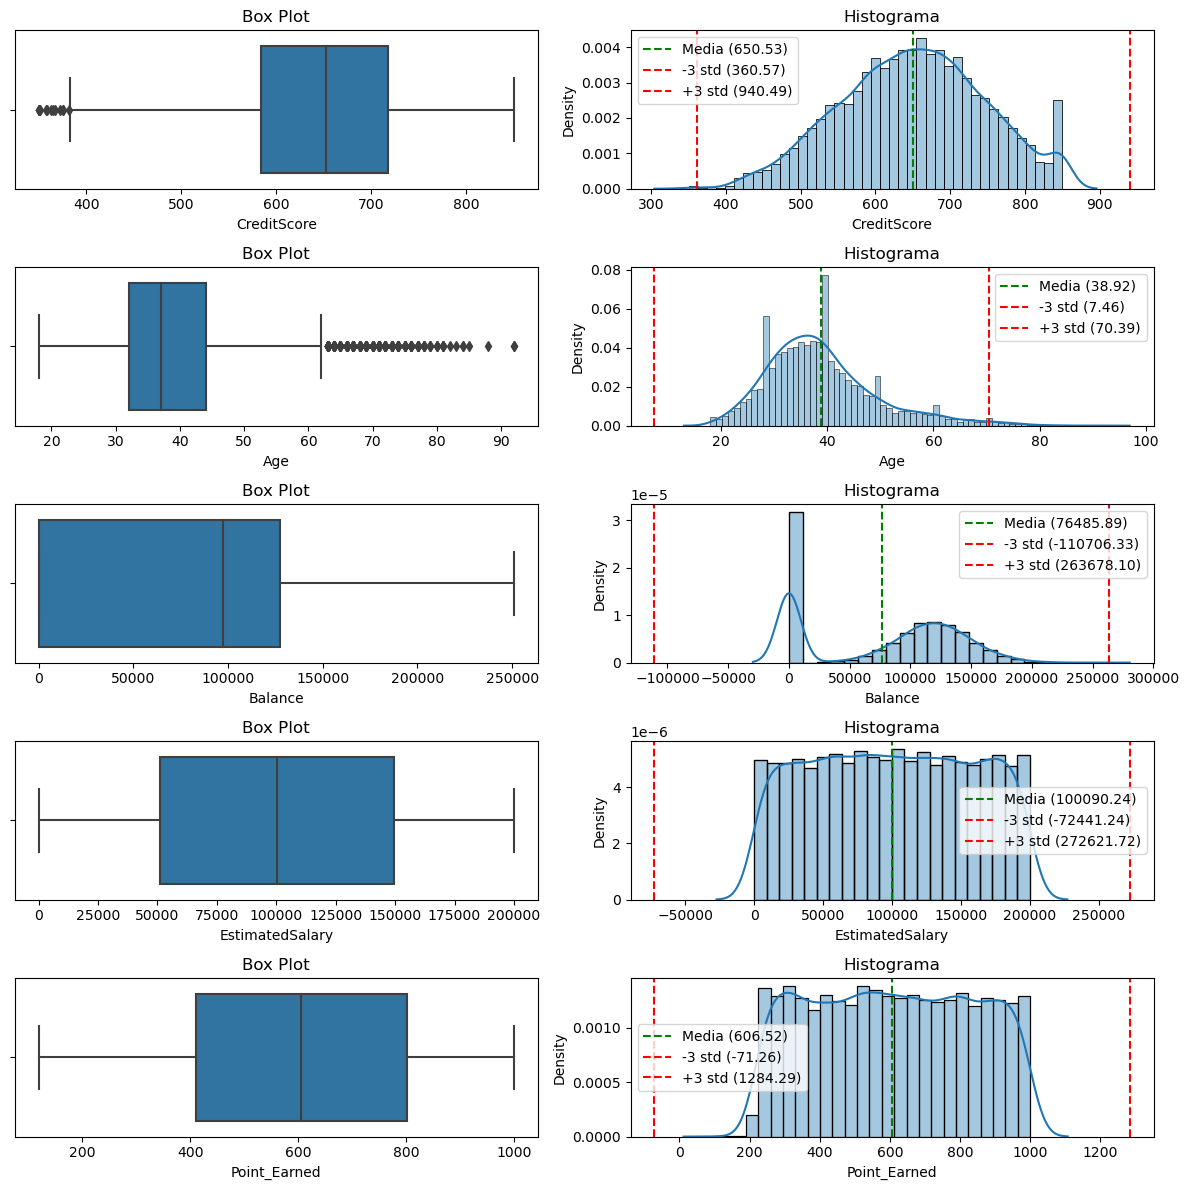

In [14]:
# Análisis de outliers

print("---- Outliers en variables númericas continuas ----")
print("")
print(numerical_cont_cols)
print("")

fig, axes = plt.subplots(len(numerical_cont_cols), 2, figsize=(12, 12))

for i, col in enumerate(numerical_cont_cols):
    sns.boxplot(ax=axes[i, 0], x=df_numerical_cont_cols[col])
    axes[i, 0].set_title(f'Box Plot', fontsize=12)
    
    sns.histplot(ax=axes[i, 1], x=df_numerical_cont_cols[col], kde=True, stat="density", kde_kws={'cut': 3}, alpha=.4)
    axes[i, 1].set_title(f'Histograma', fontsize=12)
    
    media = df_numerical_cont_cols[col].mean()
    std = df_numerical_cont_cols[col].std()
    axes[i, 1].axvline(x=media, color='green', linestyle='--', label=f'Media ({media:.2f})')
    axes[i, 1].axvline(x=media - 3 * std, color='red', linestyle='--', label=f'-3 std ({media-3*std:.2f})')
    axes[i, 1].axvline(x=media + 3 * std, color='red', linestyle='--', label=f'+3 std ({media+3*std:.2f})')
    axes[i, 1].legend()

plt.tight_layout()
plt.show()

In [15]:
# Definir el umbral para los valores atípicos (por ejemplo, 3 desviaciones estándar)
umbral = 3

outliers_data = {}

# Identificamos el número de outliers en cada variable
outliers_count_iqr = {}
outliers_count_std = {}

# Calculamos el número de outliers utilizando IQR
for col in numerical_cont_cols:
    
    media = df[col].mean()
    desviacion_estandar = df[col].std()
    
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers_count_iqr[col] = {
        "lower outliers iqr": df[df[col] < lower_bound].shape[0],
        "upper outliers iqr": df[df[col] > upper_bound].shape[0]
    }

    outliers_count_std[col] = {
        "lower outliers std": df[df[col] < media - umbral * desviacion_estandar].shape[0],
        "upper outliers std": df[df[col] > media + umbral * desviacion_estandar].shape[0]
    }

StatementMeta(, 24a44ea7-b232-44d8-8f5f-656caef7e501, 17, Finished, Available, Finished)

In [16]:
# Conteo outliers por IQR
outliers_count_iqr=pd.DataFrame(outliers_count_iqr)

# Conteo outliers por +-3 std
outliers_count_std=pd.DataFrame(outliers_count_std)

pd.concat([outliers_count_std,outliers_count_iqr], axis=0)

StatementMeta(, 24a44ea7-b232-44d8-8f5f-656caef7e501, 18, Finished, Available, Finished)

CreditScore  Age  Balance  EstimatedSalary  Point_Earned
lower outliers std            8    0        0                0             0
upper outliers std            0  133        0                0             0
lower outliers iqr           15    0        0                0             0
upper outliers iqr            0  359        0                0             0

StatementMeta(, 036f5dad-b40d-48e2-9f9d-0357c9b2db50, 71, Finished, Available, Finished)

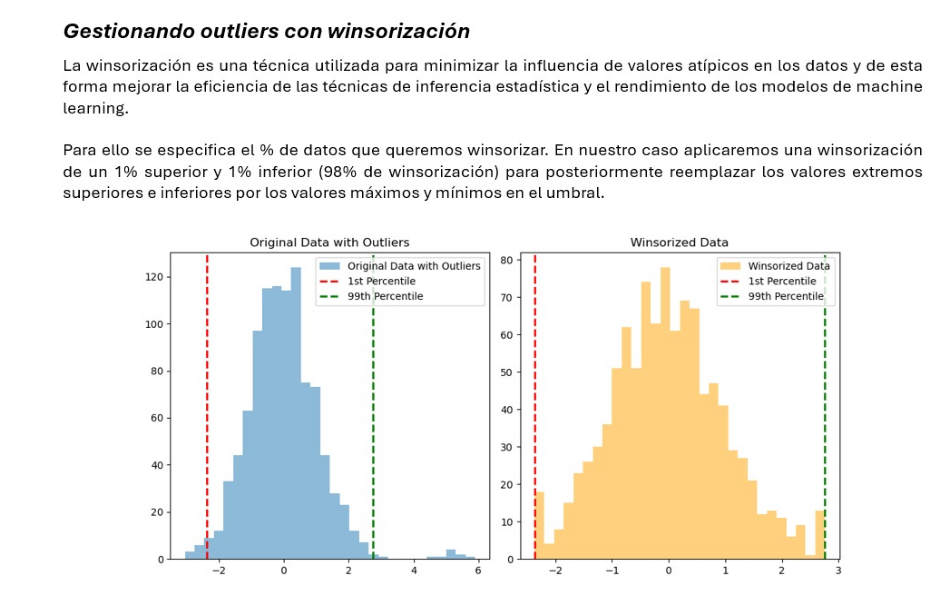

In [69]:
mostrar_imagen('/lakehouse/default/Files/Winsorizacion.jpg')

StatementMeta(, 24a44ea7-b232-44d8-8f5f-656caef7e501, 19, Finished, Available, Finished)

Columnas con outliers corregidos: ['CreditScore', 'Age']


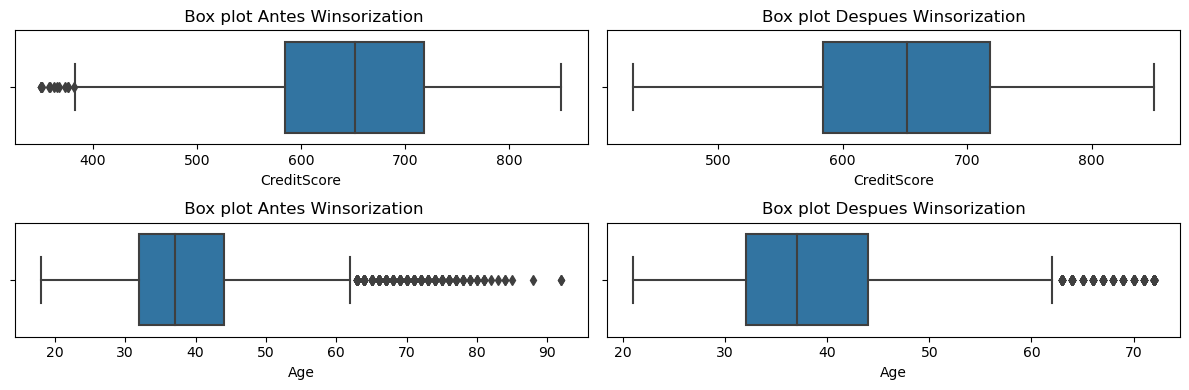

In [17]:
# Gestionando outliers con winsorización

# Seleccionamos aquellas columnas con outliers
outliers_count_std_sel=outliers_count_std.loc[:, outliers_count_std.sum() > 0]
outliers_count_std_sel
outliers_corregir = outliers_count_std_sel.columns.tolist()

print("Columnas con outliers corregidos:", outliers_corregir)

# Aplicamos la winsorización para tratar los outliers

for col in outliers_corregir:
    df[col] = mstats.winsorize(df[col], limits=[0.01, 0.01])

if len(outliers_corregir) == 1:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    axes = [axes]  # Convertir a lista para mantener la consistencia
else:
    fig, axes = plt.subplots(len(outliers_corregir), 2, figsize=(12, 4))

for i, col in enumerate(outliers_corregir):
    # Boxplot antes de la winsorización
    sns.boxplot(ax=axes[i][0], x=df_numerical_cont_cols[col])
    axes[i][0].set_title(f' Box plot Antes Winsorization', fontsize=12)

    # Boxplot después de la winsorización
    sns.boxplot(ax=axes[i][1], x=df[col])
    axes[i][1].set_title(f'Box plot Despues Winsorization', fontsize=12)

plt.tight_layout()
plt.show()

StatementMeta(, 24a44ea7-b232-44d8-8f5f-656caef7e501, 20, Finished, Available, Finished)

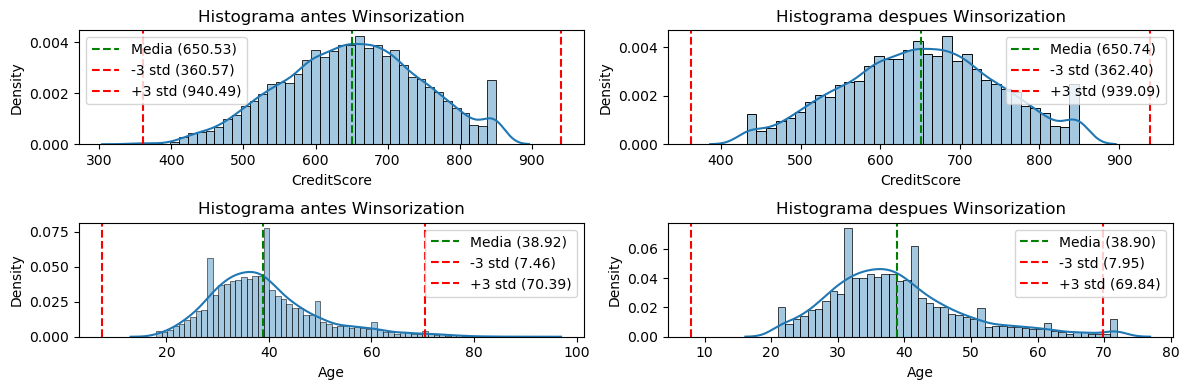

In [18]:
if len(outliers_corregir) == 1:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    axes = [axes]  # Convertir a lista para mantener la consistencia
else:
    fig, axes = plt.subplots(len(outliers_corregir), 2, figsize=(12, 4))

for i, col in enumerate(outliers_corregir):
    # Histograma antes de la winsorización
    sns.histplot(ax=axes[i, 0], x=df_numerical_cont_cols[col], kde=True, stat="density", kde_kws={'cut': 3}, alpha=.4)
    axes[i, 0].set_title(f'Histograma antes Winsorization', fontsize=12)
    
    media = df_numerical_cont_cols[col].mean()
    std = df_numerical_cont_cols[col].std()
    axes[i, 0].axvline(x=media, color='green', linestyle='--', label=f'Media ({media:.2f})')
    axes[i, 0].axvline(x=media - 3 * std, color='red', linestyle='--', label=f'-3 std ({media-3*std:.2f})')
    axes[i, 0].axvline(x=media + 3 * std, color='red', linestyle='--', label=f'+3 std ({media+3*std:.2f})')
    axes[i, 0].legend()

    # Histograma despues de la winsorización
    sns.histplot(ax=axes[i, 1], x=df[col], kde=True, stat="density", kde_kws={'cut': 3}, alpha=.4)
    axes[i, 1].set_title(f'Histograma despues Winsorization', fontsize=12)
    
    media = df[col].mean()
    std = df[col].std()
    axes[i, 1].axvline(x=media, color='green', linestyle='--', label=f'Media ({media:.2f})')
    axes[i, 1].axvline(x=media - 3 * std, color='red', linestyle='--', label=f'-3 std ({media-3*std:.2f})')
    axes[i, 1].axvline(x=media + 3 * std, color='red', linestyle='--', label=f'+3 std ({media+3*std:.2f})')
    axes[i, 1].legend()

plt.tight_layout()
plt.show()

### 2.3.4 Data Transforms: Cambiando la escala o distribución de las variables

El **feature scaling** (escalado de características) es una técnica de preprocesamiento de datos utilizada en machine learning para estandarizar las características (features) de un conjunto de datos. Esto es importante porque muchas veces las características tienen diferentes escalas y rangos, lo que puede afectar negativamente el rendimiento de algunos algoritmos de aprendizaje automático.

**¿Por qué es importante el Feature Scaling?**

- **Mejora el rendimiento del modelo:** Algoritmos como la regresión logística, SVM y KNN se ven afectados por la escala de las características. El escalado garantiza que todas las características contribuyan de manera equitativa al modelo.

- **Convergencia más rápida**: En algoritmos basados en gradiente descendente, como la regresión lineal y las redes neuronales, el escalado de características puede acelerar la convergencia.

- **Prevención de inestabilidad numérica:** Diferencias significativas en la escala de las características pueden causar problemas de inestabilidad numérica en cálculos como la distancia euclidiana.

**Métodos Comunes de Feature Scaling**

- **Normalización (Min-Max Scaling):** Escala las características para que estén en un rango específico, generalmente [0, 1].

- **Estandarización (Z-score Normalization):** Transforma las características para que tengan una media de 0 y una desviación estándar de 1.

- **Escalado por Máximo Absoluto:** Escala las características dividiendo por el valor absoluto máximo de cada característica. Útil cuando los datos contienen valores atípicos.


En nuestro caso aplicaremos, previo al entrenamiento de los distintos modelos que vamos a implementar, un escalado de las características aplicando la técnica **StandardScaler.**

**StandardScaler** es una técnica de preprocesamiento en el ámbito del aprendizaje automático que se utiliza para estandarizar las características de un conjunto de datos eliminando la media y escalando los datos para que tengan una varianza unitaria. Esto significa que transforma los datos de manera que su distribución tenga una media de cero y una desviación estándar de uno. 

Este proceso de estandarización es importante porque muchos algoritmos de aprendizaje automático funcionan mejor cuando las características se distribuyen normalmente, es decir, en forma de campana de Gauss con media cero y varianza unitaria.


**Transformación de variables categóricas:**

Para transformar las variables categóricas presentes en el dataframe usaremos las técnicas One-hot encoding y LabelEncoder, 
utilizadas en el procesamiento de datos para convertir valores categóricos en valores numéricos que los modelos de aprendizaje automático puedan entender mejor.

**One-hot encoding** es un proceso que convierte variables categóricas en una forma que se puede proporcionar a los algoritmos de ML para hacer un mejor trabajo en la predicción. Para cada valor único en una columna categórica, se crea una nueva columna binaria (0 o 1). Por otro lado, **LabelEncoder** asigna a cada valor único en la columna un número entero. Es más simple que One-hot encoding y se usa a menudo cuando la variable categórica es ordinal, lo que significa que hay un orden claro entre las categorías. Por ejemplo, si tenemos tamaños como “pequeño”, “mediano” y “grande”, LabelEncoder podría asignar 0 a “pequeño”, 1 a “mediano” y 2 a "grande"2.Ambos métodos son parte de la biblioteca de Python SciKit-learn, que es ampliamente utilizada en ciencia de datos y aprendizaje automático para preparar datos antes de entrenar modelos.

### 2.4 Feature Selection: Identificación de las variables más relevantes

StatementMeta(, 036f5dad-b40d-48e2-9f9d-0357c9b2db50, 74, Finished, Available, Finished)

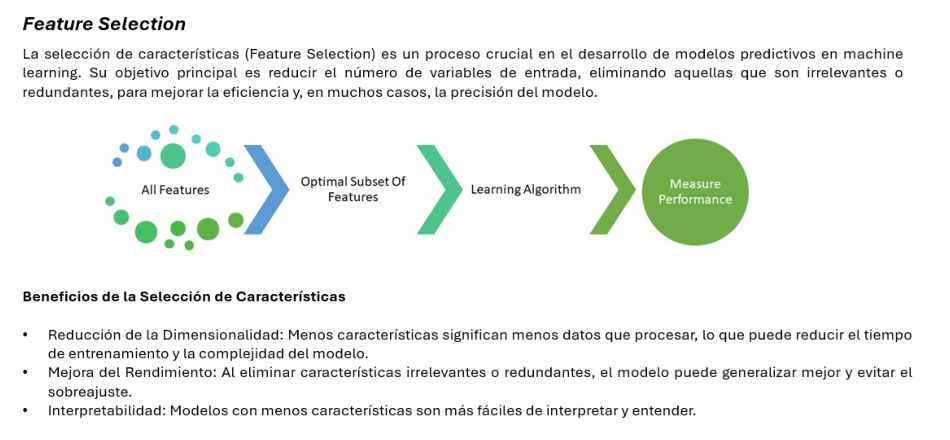

In [72]:
mostrar_imagen('/lakehouse/default/Files/FeatureSelection.jpg')

### 2.4.1 Filter Methods

StatementMeta(, 036f5dad-b40d-48e2-9f9d-0357c9b2db50, 75, Finished, Available, Finished)

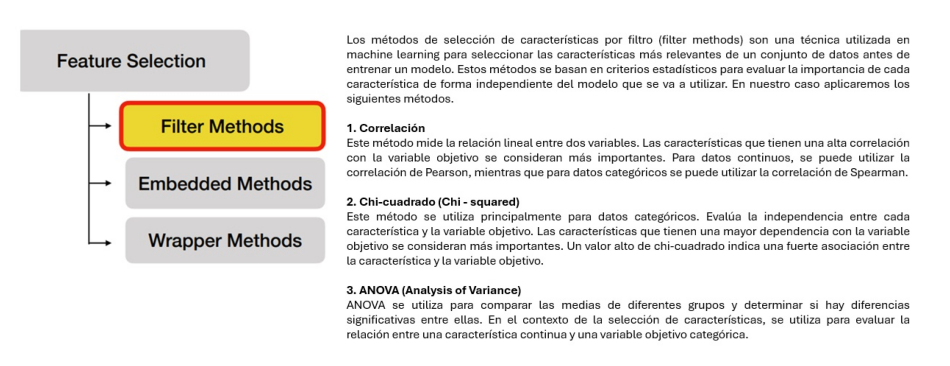

In [73]:
mostrar_imagen('/lakehouse/default/Files/FilterMethods.jpg')

#### 2.4.1 Filter Methods: Correlación, Chi-cuadrado y Anova

In [19]:
# Variables binarias y categoricas
y = df['Exited']
df2=pd.concat([df_binary_cols,df_categorical_cols,y], axis=1)

# Codificación de variables categoricas
label_encoder = LabelEncoder()
df2['Gender'] = label_encoder.fit_transform(df2['Gender'])

# Codificación Card_Type y Geografhy para prueba chi2
df2['Card_Type'] = label_encoder.fit_transform(df2['Card_Type'])
df2['Geography'] = label_encoder.fit_transform(df2['Geography'])

X = df2.drop(['Exited'], axis=1)
y = df2['Exited']

# Calcular la prueba de chi-cuadrado
chi2_stats, p_values = chi2(X, y)

# Calcular la correlación con la variable 'Exited'
correlation_with_exited = (df2.corr()['Exited'].drop('Exited') * 100).round(2)

# Interpretar los resultados

alpha = 0.05

# Crear un DataFrame con los resultados para cada variable
results_df2 = pd.DataFrame({
    'Variable': X.columns,
    'chi-cuadrado': chi2_stats.round(3),
    'Valor p': p_values.round(3),
    'Sign si < alpha': p_values < alpha,
    'Correlación (%)': correlation_with_exited.values
})

print('Prueba de Chi-cuadrado y correlación')
print('---')
print(f"alpha: {alpha}")
print('---')
print(results_df2)

StatementMeta(, 24a44ea7-b232-44d8-8f5f-656caef7e501, 21, Finished, Available, Finished)

Prueba de Chi-cuadrado y correlación
---
alpha: 0.05
---
         Variable  chi-cuadrado  Valor p  Sign si < alpha  Correlación (%)
0       HasCrCard         0.143    0.705            False            -0.70
1  IsActiveMember       118.544    0.000             True           -15.64
2        Complain      7887.607    0.000             True            99.57
3       Geography        11.702    0.001             True             3.57
4          Gender        51.302    0.000             True           -10.63
5       Card_Type         0.985    0.321            False            -1.09


**HasCrCard** y **Card_Type** muestran muy poca dependencia y correlación con la variable Objetivo Exit.
**Complain** muestra una correlación lineal casi perfecta y debe por tanto ser descartada a la hora de construir un modelo de ML.

In [20]:
# Eliminamos Complain por casi perfecta correlación
df=df.drop(columns = ['Complain'],axis=1)

StatementMeta(, 24a44ea7-b232-44d8-8f5f-656caef7e501, 22, Finished, Available, Finished)

StatementMeta(, 24a44ea7-b232-44d8-8f5f-656caef7e501, 23, Finished, Available, Finished)

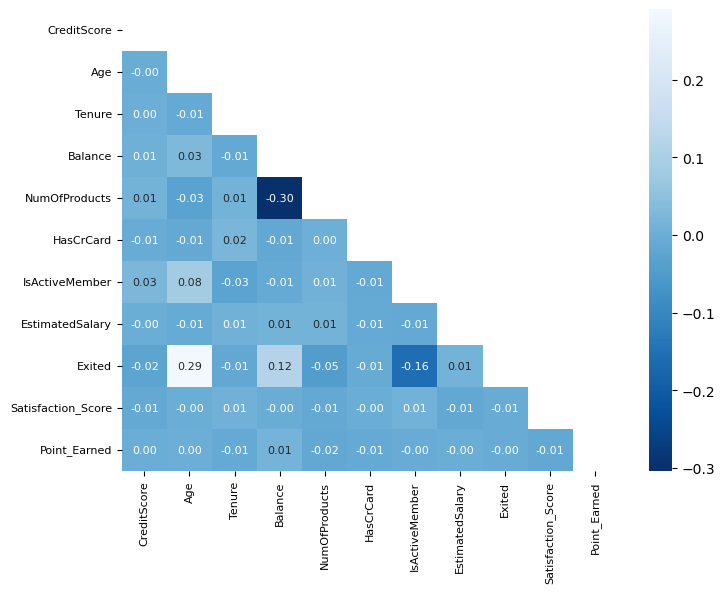

Correlation with Exited : 
Age                   0.29
Balance               0.12
EstimatedSalary       0.01
Point_Earned         -0.00
Tenure               -0.01
HasCrCard            -0.01
Satisfaction_Score   -0.01
CreditScore          -0.02
NumOfProducts        -0.05
IsActiveMember       -0.16
Name: Exited, dtype: float64

Variables con significación >= 0.05 con Exited: 
Age               0.29
Balance           0.12
NumOfProducts    -0.05
IsActiveMember   -0.16
Name: Exited, dtype: float64


In [21]:
# Variables numericas

# Usaremos una correlation matrix heatmap para visualizar las correlaciones entre las variables numericas
# Podemos visualizar las correlaciones entre variables utilizando una matriz de correlación (heatmap)
# Calcular la matriz de correlación
corr = df.select_dtypes(include=['int', 'float']).corr()

# Crear una máscara para la mitad superior
mask = np.triu(np.ones_like(corr, dtype=bool))

# Configurar la figura
plt.figure(figsize=(8, 6))

# Crear el heatmap con la máscara
sns.heatmap(corr, mask=mask, annot=True, center=0, cmap='Blues_r', fmt='.2f', annot_kws={'size': 8})

# Ajustar el tamaño de las etiquetas
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.show()

# Ｃorrelation with Ｅxited
correlation_with_exited = (df.select_dtypes(include=['int', 'float']).corr()['Exited']).round(2)
# Excluir Exited
correlation_with_exited = correlation_with_exited[correlation_with_exited.index != 'Exited']
sorted_correlation = correlation_with_exited.sort_values(ascending=False)
print(f'Correlation with Exited : \n{sorted_correlation}')

# Seleccionar solo las que tengan valores >= 0.05
selected_variables = sorted_correlation[(sorted_correlation >= 0.05) | (sorted_correlation <= -0.05)]
print()
print(f'Variables con significación >= 0.05 con Exited: \n{selected_variables}')

In [22]:
# Mostrar variables que tengan alta correlación entre ellas

print()
print(f'Pares de Variables con significación >= 0.10 o <= -0.10: \n')

# Calcular la matriz de correlación
corr_matrix = df.select_dtypes(include=['int', 'float']).drop(columns=['Exited']).corr().round(2)

# Filtrar los pares de valores con correlación > 0.1 o < -0.1
threshold = 0.1
filtered_pairs = corr_matrix[(corr_matrix > threshold) | (corr_matrix < -threshold)]

# Convertir la matriz filtrada a un formato de pares
pairs = filtered_pairs.stack().reset_index()
pairs.columns = ['Variable1', 'Variable2', 'Correlation']

# Eliminar los pares duplicados y los pares de la diagonal (correlación de una variable consigo misma)
pairs = pairs[pairs['Variable1'] != pairs['Variable2']]
pairs = pairs.drop_duplicates(subset=['Correlation'])

# Mostrar los resultados
print(pairs)

StatementMeta(, 24a44ea7-b232-44d8-8f5f-656caef7e501, 24, Finished, Available, Finished)


Pares de Variables con significación >= 0.10 o <= -0.10: 

  Variable1      Variable2  Correlation
4   Balance  NumOfProducts         -0.3


StatementMeta(, 24a44ea7-b232-44d8-8f5f-656caef7e501, 25, Finished, Available, Finished)

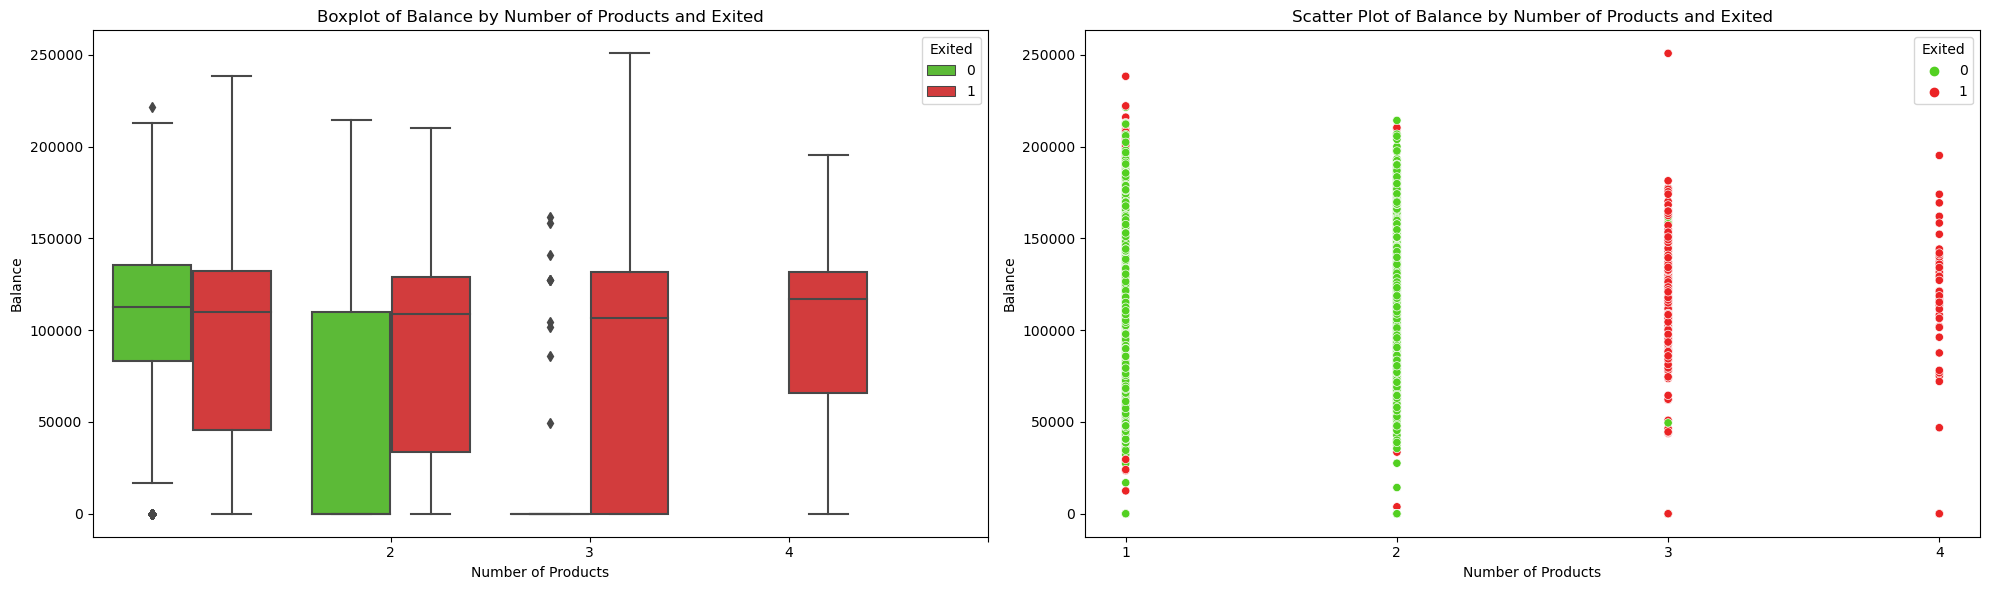

In [23]:
# Analizamos Balance y NumOfProducts

# Definir los colores
colors = ["#53D021", "#EB2325"]

# Crear subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Crear el boxplot
sns.boxplot(ax=axes[0], x='NumOfProducts', y='Balance', hue='Exited', data=df, palette=colors)
axes[0].set_title('Boxplot of Balance by Number of Products and Exited')
axes[0].set_xlabel('Number of Products')
axes[0].set_ylabel('Balance')
axes[0].set_xticks(df['NumOfProducts'].unique())  # Asegurar que las etiquetas del eje x sean discretas

# Crear el gráfico de dispersión
sns.scatterplot(ax=axes[1], x='NumOfProducts', y='Balance', hue='Exited', data=df, palette=colors)
axes[1].set_title('Scatter Plot of Balance by Number of Products and Exited')
axes[1].set_xlabel('Number of Products')
axes[1].set_ylabel('Balance')
axes[1].set_xticks(df['NumOfProducts'].unique())  # Asegurar que las etiquetas del eje x sean discretas

# Ajustar el diseño
plt.tight_layout()
plt.show()

#### 2.4.2 Filter Methods empleando el metodo K-best

**Implementación en Python de los métodos de selección de características por filtro (filter methods) con SelectKbest**

**SelectKBest** es una clase en la librería scikit-learn que implementa un método de selección de características. No es un algoritmo en sí mismo, sino una herramienta que te permite aplicar los diferentes criterios (algoritmos) de selección de características.

- La clase SelectKBest selecciona las mejores características basándose en una función de puntuación que tú eliges. Por ejemplo, puedes usar chi2 para el test de chi-cuadrado, f_classif para ANOVA, mutual_info_classif para información mutua. Estos son los algoritmos que realmente calculan la relevancia de cada característica.

**Cuando usar chi2:**

La función chi2 es adecuada para características no negativas y se utiliza principalmente en tareas de clasificación con variables categóricas. SelectKBest con la función chi2 se puede usar con variables numéricas, pero requiere que las variables numéricas sean no negativas. Si tienes valores negativos, necesitarás discretizarlas (convertirlas en categorías) antes de aplicar chi2.

**ANOVA F -value (f_classif):**

- Mide la relación lineal entre las características y la variable objetivo.

- Para aplicarlo las variables independientes (características) deben ser numéricas pues se evalúa la varianza entre las medias de estas características para diferentes clases, y la variable Dependiente (objetivo) debe ser categórica, pues El ANOVA F-value se utiliza para determinar si las medias de las características numéricas son significativamente diferentes entre las distintas categorías de la variable objetivo

Para seleccionar las variables más significativas con el metodo K-best usaremos Chi-cuadrado (sin discretización
y con discretización de las variables númericas) y f_classif para realizar una prueba de ANOVA.

In [24]:
# Primero codificamos las variables categoricas 

#Codificación One-hot para las variables 'Geography' y 'Card Type'
df= pd.get_dummies(df, columns=['Geography', 'Card_Type'], drop_first=True)

# Codificación de etiquetas para la variable 'Gender'
label_encoder = LabelEncoder()
df['Gender'] = label_encoder.fit_transform(df['Gender'])

StatementMeta(, 24a44ea7-b232-44d8-8f5f-656caef7e501, 26, Finished, Available, Finished)

In [25]:
X = df.drop(['Exited'], axis=1)
# Convertir columnas booleanas a enteros por si evita warnings
#X = X.astype(int)

y = df['Exited']
#Discretizar las variables numéricas para chi-cuadrado
discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
X_discretized = discretizer.fit_transform(X)

# Crear selectores de características
selectors = {
    'chi2': SelectKBest(score_func=mutual_info_classif, k=10),
    'chi2 discretizado': SelectKBest(score_func=chi2, k=10),
    'f_classif': SelectKBest(score_func=f_classif, k=10),
}

# DataFrame para almacenar los resultados
results = pd.DataFrame(0, index=selectors.keys(), columns=X.columns)

# Aplicar cada selector y almacenar los resultados
for method, selector in selectors.items():
    if method == 'chi2 discretizado':
        X_new = selector.fit_transform(X_discretized, y)
    else:
        X_new = selector.fit_transform(X, y)
    
    selected_features = selector.get_support(indices=True)
    results.loc[method, [X.columns[i] for i in selected_features]] = 1


StatementMeta(, 24a44ea7-b232-44d8-8f5f-656caef7e501, 27, Finished, Available, Finished)

2024-08-31:11:47:08,251 WARNING  [tracking_store.py:153] log_inputs not supported


2024-08-31:11:47:17,444 WARNING  [tracking_store.py:153] log_inputs not supported


2024-08-31:11:47:21,99 WARNING  [tracking_store.py:153] log_inputs not supported


2024-08-31:11:47:24,616 WARNING  [tracking_store.py:153] log_inputs not supported


2024-08-31:11:47:28,198 WARNING  [tracking_store.py:153] log_inputs not supported


2024-08-31:11:47:31,812 WARNING  [tracking_store.py:153] log_inputs not supported


2024-08-31:11:47:35,582 WARNING  [tracking_store.py:153] log_inputs not supported


2024-08-31:11:47:39,182 WARNING  [tracking_store.py:153] log_inputs not supported


2024-08-31:11:47:42,807 WARNING  [tracking_store.py:153] log_inputs not supported


2024-08-31:11:47:46,270 WARNING  [tracking_store.py:153] log_inputs not supported


2024-08-31:11:47:49,971 WARNING  [tracking_store.py:153] log_inputs not supported


2024-08-31:11:47:53,442 WARNING  [tracking_store.py:153] log_inputs not supported


2024-08-31:11:47:57,65 WARNING  [tracking_store.py:153] log_inputs not supported


2024-08-31:11:48:00,561 WARNING  [tracking_store.py:153] log_inputs not supported


2024-08-31:11:48:04,32 WARNING  [tracking_store.py:153] log_inputs not supported


2024-08-31:11:48:07,555 WARNING  [tracking_store.py:153] log_inputs not supported


2024-08-31:11:48:11,102 WARNING  [tracking_store.py:153] log_inputs not supported


2024-08-31:11:48:14,552 WARNING  [tracking_store.py:153] log_inputs not supported


2024-08-31:11:48:18,78 WARNING  [tracking_store.py:153] log_inputs not supported


2024-08-31:11:48:21,509 WARNING  [tracking_store.py:153] log_inputs not supported


2024-08-31:11:48:24,938 WARNING  [tracking_store.py:153] log_inputs not supported


2024-08-31:11:48:28,394 WARNING  [tracking_store.py:153] log_inputs not supported


2024-08-31:11:48:31,981 WARNING  [tracking_store.py:153] log_inputs not supported


2024-08-31:11:48:35,415 WARNING  [tracking_store.py:153] log_inputs not supported


2024-08-31:11:48:38,945 WARNING  [tracking_store.py:153] log_inputs not supported


2024-08-31:11:48:42,437 WARNING  [tracking_store.py:153] log_inputs not supported


2024-08-31:11:48:45,924 WARNING  [tracking_store.py:153] log_inputs not supported


2024-08-31:11:48:49,382 WARNING  [tracking_store.py:153] log_inputs not supported


2024-08-31:11:48:52,904 WARNING  [tracking_store.py:153] log_inputs not supported


2024-08-31:11:48:56,274 WARNING  [tracking_store.py:153] log_inputs not supported


2024-08-31:11:48:59,664 WARNING  [tracking_store.py:153] log_inputs not supported


2024-08-31:11:49:03,417 WARNING  [tracking_store.py:153] log_inputs not supported


In [26]:
#Transponer el DataFrame 'results'
results_transposed = results.T

# Añadir una columna de suma con el total
results_transposed['Total'] = results_transposed.sum(axis=1)

# Ordenar el DataFrame en orden descendente por la columna 'Total'
results_Kbest = results_transposed.sort_values(by='Total', ascending=False)
print('Feature Selection: Univariante Feature Selection (SelectKbest) (1:Feature seleccionada , 0: No seleccionada)')
print('--------------------------')
print(results_Kbest)

StatementMeta(, 24a44ea7-b232-44d8-8f5f-656caef7e501, 28, Finished, Available, Finished)

Feature Selection: Univariante Feature Selection (SelectKbest) (1:Feature seleccionada , 0: No seleccionada)
--------------------------
                    chi2  chi2 discretizado  f_classif  Total
Gender                 1                  1          1      3
Age                    1                  1          1      3
Balance                1                  1          1      3
NumOfProducts          1                  1          1      3
IsActiveMember         1                  1          1      3
Geography_Germany      1                  1          1      3
CreditScore            0                  1          1      2
Tenure                 0                  1          1      2
Geography_Spain        0                  1          1      2
Card_Type_GOLD         0                  1          1      2
HasCrCard              1                  0          0      1
EstimatedSalary        1                  0          0      1
Point_Earned           1                  0          0    

In [27]:
# Seleccionamos las filas donde Total >= 2
filtered_df = results_Kbest[results_Kbest['Total'] >= 2]

# Convertimos el índice de las filas seleccionadas en una lista
Best_results_kbest = filtered_df.index.tolist()

print("Las variables que han sido seleccionadas entre las 10 más significativas por Kbest son:\n")
print(Best_results_kbest)

# Seleccionamos las filas donde Total = 0
filtered_df2 = results_Kbest[results_Kbest['Total'] == 0]

# Convertimos el índice de las filas seleccionadas en una lista
Worst_results_kbest = filtered_df2.index.tolist()

print("----------------------")
print("Las variables que no han sido seleccionadas entre las 10 más significativas por Kbest son:\n")
print(Worst_results_kbest)

StatementMeta(, 24a44ea7-b232-44d8-8f5f-656caef7e501, 29, Finished, Available, Finished)

Las variables que han sido seleccionadas entre las 10 más significativas por Kbest son:

['Gender', 'Age', 'Balance', 'NumOfProducts', 'IsActiveMember', 'Geography_Germany', 'CreditScore', 'Tenure', 'Geography_Spain', 'Card_Type_GOLD']
----------------------
Las variables que no han sido seleccionadas entre las 10 más significativas por Kbest son:

['Satisfaction_Score', 'Card_Type_SILVER']


### 2.4.3 Embedded Methods: RandomForest

StatementMeta(, 71a85b1a-cfd1-49f7-b217-b4a410ba84d5, 39, Finished, Available, Finished)

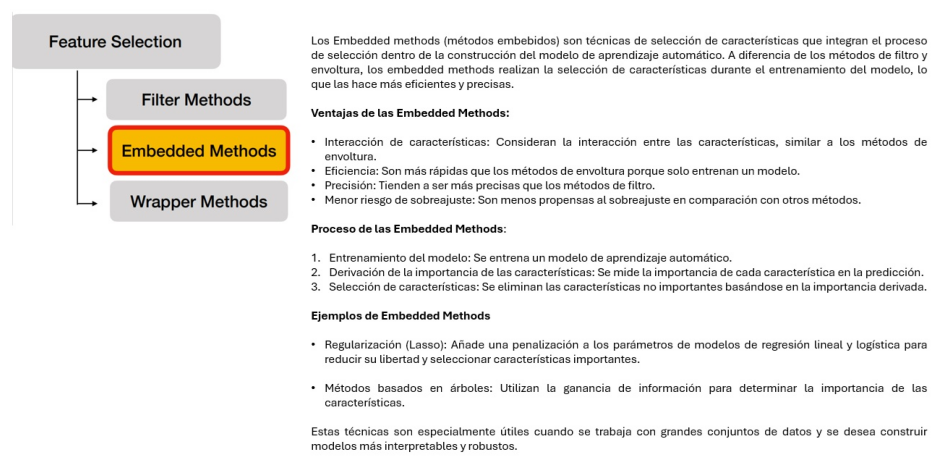

In [37]:
mostrar_imagen('/lakehouse/default/Files/Embedded Methods.jpg')

En nuestro caso entrenaremos un modelo RandomForest para seleccionar las 10 mejores caracteristicas de nuestro df

In [28]:
#Añado una variable aleatoria que me va a servir para comparar con otras y ver un posible punto de corte para la significación
np.random.seed(123)
random_values = np.random.rand(df.shape[0])

# Remodelar random_values para que coincida con la forma del DataFrame
x1 = np.abs(np.random.randn(df.shape[0]).reshape(-1, 1))
df['Var']=x1

StatementMeta(, 24a44ea7-b232-44d8-8f5f-656caef7e501, 30, Finished, Available, Finished)

In [29]:
# función para entrenar el modelo

def entrenar_random_forest(X, umbral):

    #Aplicación RandomOverSampler para correfgir desequilibrio
    # Dividir los datos en conjuntos de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

    # Aplicar RandomOverSampler solo al conjunto de entrenamiento
    rand_over_samp = RandomOverSampler(random_state=42)
    X_train, y_train = rand_over_samp.fit_resample(X_train, y_train)
    X_train.shape,X_test.shape,y_train.shape,y_test.shape

    # Entrenar el modelo de Random Forest
    forest = RandomForestClassifier(max_depth=10, min_samples_split=20, n_estimators=500, random_state=1)
    forest.fit(X_train, y_train)
    
   # Obtener las importancias de las características
    importances = forest.feature_importances_
    
    # Crear una serie de pandas con las importancias
    forest_importances = pd.Series(importances, index=X.columns)
    
    # Seleccionar las características con importancia mayor al umbral
    selected_features = forest_importances[forest_importances > umbral].index.tolist()
    
    # Graficar las importancias de las características
    fig, ax = plt.subplots(figsize=(8, 4))
    background_color = "#ffe6e6"
    fig.patch.set_facecolor(background_color)
    ax.set_facecolor(background_color)
    forest_importances.sort_values().plot.bar(ax=ax, color=sns.color_palette('viridis', len(forest_importances)))
    ax.set_title("Feature importances")
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()
    plt.show()
    
    # Mostrar las precisiones de entrenamiento y prueba
    
    print('Training accuracy:', np.mean(forest.predict(X_train) == y_train) * 100)
    print('Test accuracy:', np.mean(forest.predict(X_test) == y_test) * 100)
    # Ordenar de mayor a menor
    sorted_importances = sorted(forest_importances.items(), key=lambda item: item[1], reverse=True)

    # Crear un DataFrame a partir de la lista de tuplas ordenadas
    df_importances_forest = pd.DataFrame(sorted_importances, columns=['Feature', 'Importance'])
    print('---------------')
    print(df_importances_forest)
    print('---------------')
    print(f"Las variables que han sido seleccionadas con importancia mayor a {umbral} son:\n")
    df_importances_umbral = df_importances_forest[df_importances_forest['Importance'] >= umbral]
    print(df_importances_umbral)

    return selected_features, forest

StatementMeta(, 24a44ea7-b232-44d8-8f5f-656caef7e501, 31, Finished, Available, Finished)

StatementMeta(, 24a44ea7-b232-44d8-8f5f-656caef7e501, 32, Finished, Available, Finished)

2024-08-31:11:51:44,928 WARNING  [tracking_store.py:153] log_inputs not supported


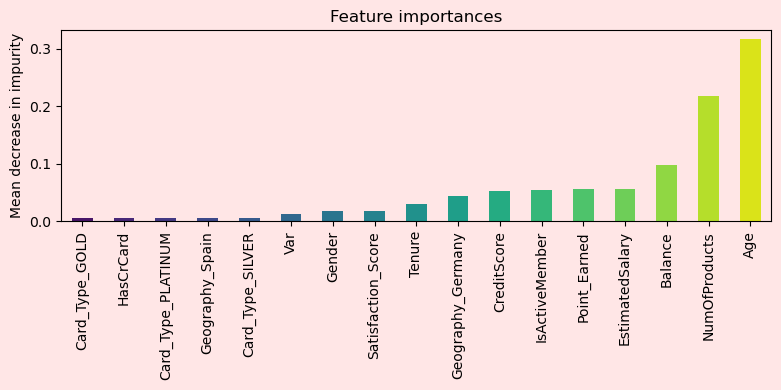

2024-08-31:11:52:01,255 WARNING  [tracking_store.py:153] log_inputs not supported
2024-08-31:11:52:01,515 WARNING  [tracking_store.py:153] log_inputs not supported


Training accuracy: 90.17969451931717
Test accuracy: 82.86666666666666
---------------
               Feature  Importance
0                  Age    0.316180
1        NumOfProducts    0.218602
2              Balance    0.097072
3      EstimatedSalary    0.055907
4         Point_Earned    0.055415
5       IsActiveMember    0.054549
6          CreditScore    0.053187
7    Geography_Germany    0.044066
8               Tenure    0.029077
9   Satisfaction_Score    0.017550
10              Gender    0.017318
11                 Var    0.012787
12    Card_Type_SILVER    0.006322
13     Geography_Spain    0.006200
14  Card_Type_PLATINUM    0.005465
15           HasCrCard    0.005445
16      Card_Type_GOLD    0.004860
---------------
Las variables que han sido seleccionadas con importancia mayor a 0.055 son:

           Feature  Importance
0              Age    0.316180
1    NumOfProducts    0.218602
2          Balance    0.097072
3  EstimatedSalary    0.055907
4     Point_Earned    0.055415


In [30]:
X= df.drop(['Exited'], axis=1)
# Convertir las columnas booleanas a enteros
X = X.round().astype(int)
umbral=0.055
selected_features, forest = entrenar_random_forest(X, umbral)

Entremo el modelo con todas las variables
Establecer un umbral de corte sobre 0,05 que puede ser ajustado en función de la importancia de la variable aleatoria Var

### 2.4.4 Conclusiones Feature Selection

**Variables muy poco significativas**

- HasCrCard: Denota si un cliente tiene una tarjeta de crédito. Indica si el cliente tiene tarjeta de crédito (1 = Sí, 0 = No).
- Card Type: Indica el tipo de tarjeta que posee el cliente.
- Satisfaction Score: Puntuación proporcionada por el cliente sobre la resolución de su queja.

**Variables más significativas**

- Age: Edad de los clientes.
- Balance: Saldo de los clientes.
- NumOfProducts: Indica el número de productos que un cliente ha adquirido a través del banco. 
- IsActiveMember: Indica si el cliente es un miembro activo (1 = Sí, 0 = No).

**Variables con significación baja**

- Geography: Pais de residencia del cliente.
- Gender: Género del cliente.
- Tenure: Se refiere al número de años que el cliente ha estado con el banco.
- EstimatedSalary: Salario de los clientes.
- Points Earned: Refleja los puntos que el cliente ha ganado al usar su tarjeta de crédito

In [31]:
# Seleccionamos las features que vamos a usar en nuestro entrenamiento, descartando las no significativas
selected_features = ['CreditScore', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'IsActiveMember', 'EstimatedSalary', 'Point_Earned', 'Geography_Germany','Geography_Spain' ]

StatementMeta(, 24a44ea7-b232-44d8-8f5f-656caef7e501, 33, Finished, Available, Finished)

### 2.5 Reducción de la dimensionalidad de los datos

No se requiere

### 2.6 Feature engineering: Creación de nuevas variables

No se requiere

### 2.7 Guardamos modelo tras EDA

In [32]:
# Eliminamos Var
df=df.drop(columns = ['Var'],axis=1)

# Guardar el DataFrame en un nuevo archivo CSV
df.to_csv("/lakehouse/default/Files/Churn-RecordsEDA.csv", index=False)

StatementMeta(, 24a44ea7-b232-44d8-8f5f-656caef7e501, 34, Finished, Available, Finished)